## 1. Установка зависимостей


In [1]:
%pip install torch torchvision matplotlib pandas numpy tqdm pillow scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Импорты
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torch.optim as optim
import time
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

In [3]:
# Проверим доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Using device: {device}")

Using device: mps


## 2. Скачивание и подготовка датасета GTSRB


In [4]:
# Скачивание датасета GTSRB
import urllib.request
import zipfile
import shutil
from pathlib import Path

DOWNLOAD_PART_URL = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/"

def download_file(url, filename):
    """Скачивает файл с progress bar"""
    if not url:
        print(f"⚠️  URL для {filename} не указан - пропускаем скачивание")
        return False
        
    print(f"📥 Скачиваем {filename}...")
    try:
        urllib.request.urlretrieve(url + filename, filename)
        print(f"✅ {filename} скачан успешно")
        return True
    except Exception as e:
        print(f"❌ Ошибка скачивания {filename}: {e}")
        return False

def extract_zip(zip_path, extract_to):
    """Извлекает zip архив"""
    print(f"📦 Разархивируем {zip_path}...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"✅ {zip_path} разархивирован в {extract_to}")
        return True
    except Exception as e:
        print(f"❌ Ошибка разархивирования {zip_path}: {e}")
        return False

# Создаем папки для данных
data_dir = Path("data")
gtsrb_dir = Path(data_dir, "GTSRB")
data_dir.mkdir(exist_ok=True)
gtsrb_dir.mkdir(exist_ok=True)

training_path = Path(gtsrb_dir, "Final_Training")
test_path = Path(gtsrb_dir, "Final_Test")

training_images_path = Path(training_path, "Images")
test_images_path = Path(test_path, "Images")

print("=== Скачивание датасета GTSRB ===")

# Скачиваемые файлы
training_zip = "GTSRB_Final_Training_Images.zip"
test_zip = "GTSRB_Final_Test_Images.zip"
gt_zip = "GTSRB_Final_Test_GT.zip"

# Проверяем существование файлов
if not Path(training_zip).exists():
    download_file(DOWNLOAD_PART_URL, training_zip)
else:
    print(f"✅ {training_zip} уже существует")

if not Path(test_zip).exists():
    download_file(DOWNLOAD_PART_URL, test_zip)
else:
    print(f"✅ {test_zip} уже существует")

if not Path(gt_zip).exists():
    download_file(DOWNLOAD_PART_URL, gt_zip)
else:
    print(f"✅ {gt_zip} уже существует или URL не указан")

print("\n=== Разархивирование ===")

# Разархивируем тренировочные данные
final_test_csv = "GT-final_test.csv"
final_test_csv_path = Path(gtsrb_dir, final_test_csv)

if Path(training_zip).exists() and not training_path.exists():
    extract_zip(training_zip, str(data_dir))

# Разархивируем тестовые данные  
if Path(test_zip).exists() and not test_path.exists():
    extract_zip(test_zip, str(data_dir))

# Разархивируем GT файл (если есть)
if Path(gt_zip).exists() and not final_test_csv_path.exists():
    extract_zip(gt_zip, str(gtsrb_dir))

# Проверяем структуру данных
if training_path.exists():
    num_classes = len(list(training_path.iterdir()))
    print(f"✅ Тренировочные данные найдены: {num_classes} классов")
else:
    print("⚠️  Тренировочные данные не найдены")

if test_images_path.exists():
    test_images = len(list(test_images_path.glob("*.ppm")))
    print(f"✅ Тестовые данные найдены: {test_images} изображений")
else:
    print("⚠️  Тестовые данные не найдены")

print(f"\n📁 Структура данных:")
print(f"  📂 {data_dir}/")
print(f"    📂 GTSRB/")
print(f"      📂 Final_Training/Images/  ({'✅ найдено' if training_path.exists() else '❌ отсутствует'})")
print(f"      📂 Final_Test/Images/      ({'✅ найдено' if test_images_path.exists() else '❌ отсутствует'})")
print(f"      📄 GT-final_test.csv       ({'✅ найдено' if Path(gtsrb_dir, 'GT-final_test.csv').exists() else '❌ отсутствует'})")


=== Скачивание датасета GTSRB ===
📥 Скачиваем GTSRB_Final_Training_Images.zip...
✅ GTSRB_Final_Training_Images.zip скачан успешно
📥 Скачиваем GTSRB_Final_Test_Images.zip...
✅ GTSRB_Final_Test_Images.zip скачан успешно
📥 Скачиваем GTSRB_Final_Test_GT.zip...
✅ GTSRB_Final_Test_GT.zip скачан успешно

=== Разархивирование ===
📦 Разархивируем GTSRB_Final_Training_Images.zip...
✅ GTSRB_Final_Training_Images.zip разархивирован в data
📦 Разархивируем GTSRB_Final_Test_Images.zip...
✅ GTSRB_Final_Test_Images.zip разархивирован в data
📦 Разархивируем GTSRB_Final_Test_GT.zip...
✅ GTSRB_Final_Test_GT.zip разархивирован в data/GTSRB
✅ Тренировочные данные найдены: 1 классов
✅ Тестовые данные найдены: 12630 изображений

📁 Структура данных:
  📂 data/
    📂 GTSRB/
      📂 Final_Training/Images/  (✅ найдено)
      📂 Final_Test/Images/      (✅ найдено)
      📄 GT-final_test.csv       (✅ найдено)


In [5]:
# Сплит данных на train/validation
import pandas as pd
from sklearn.model_selection import train_test_split

def create_train_val_split(base_dir, output_base_dir=data_dir, test_size=0.2, random_state=42):
    """
    Создает сплит train/validation из GTSRB данных
    """
    print("=== Создание train/validation сплита ===")
    
    base_path = Path(base_dir, 'Images')
    if not base_path.exists():
        print(f"❌ Папка {base_dir} не найдена!")
        return False
        
    # Собираем все образцы
    all_samples = []

    print("📊 Анализируем структуру данных...")
    for class_dir in sorted(base_path.iterdir()):
        if not class_dir.is_dir():
            continue
            
        class_id = class_dir.name
        csv_file = class_dir / f"GT-{class_id}.csv"
        
        if not csv_file.exists():
            print(f"⚠️  CSV файл не найден для класса {class_id}")
            continue
            
        df = pd.read_csv(csv_file, sep=";")
        
        for _, row in df.iterrows():
            filename = row["Filename"]
            seq_id = filename.split("_")[0]  # sequence ID (например "00014")
            full_path = class_dir / filename
            
            if full_path.exists():
                all_samples.append({
                    "path": str(full_path),
                    "class_id": row["ClassId"],
                    "seq_id": seq_id
                })
    
    if not all_samples:
        print("❌ Не найдено образцов для сплита!")
        return False
        
    df_all = pd.DataFrame(all_samples)
    
    print(f"📈 Всего образцов: {len(df_all)}")
    print(f"📈 Классов: {df_all['class_id'].nunique()}")
    print(f"📈 Уникальных последовательностей: {df_all['seq_id'].nunique()}")
    
    # Делаем split по seq_id (чтобы одна сцена не попала в обе выборки)
    unique_seq = df_all["seq_id"].unique()
    train_seq, val_seq = train_test_split(
        unique_seq, 
        test_size=test_size, 
        random_state=random_state, 
        shuffle=True
    )
    
    train_df = df_all[df_all["seq_id"].isin(train_seq)]
    val_df = df_all[df_all["seq_id"].isin(val_seq)]
    
    print(f"📊 Train размер: {len(train_df)} образцов ({len(train_seq)} последовательностей)")
    print(f"📊 Val размер:   {len(val_df)} образцов ({len(val_seq)} последовательностей)")
    
    # Проверяем распределение классов
    train_classes = train_df['class_id'].nunique()
    val_classes = val_df['class_id'].nunique()
    print(f"📊 Train классов: {train_classes}")
    print(f"📊 Val классов:   {val_classes}")
    
    # Сохраняем сплит
    def save_split(df, split_name, output_dir):
        split_dir = Path(output_dir, split_name)
        split_dir.mkdir(parents=True, exist_ok=True)
        
        saved_count = 0
        for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Сохранение {split_name}"):
            class_id = str(row["class_id"]).zfill(5)  # папка как 00000..00042
            class_dir = Path(split_dir, class_id)
            class_dir.mkdir(exist_ok=True)
            
            src_path = Path(row["path"])
            dst_path = Path(class_dir, src_path.name)
            
            try:
                shutil.copy(src_path, dst_path)
                saved_count += 1
            except Exception as e:
                print(f"⚠️  Ошибка копирования {src_path}: {e}")
        
        print(f"✅ {split_name}: скопировано {saved_count} файлов")
        return saved_count
    
    # Создаем train и validation наборы
    train_count = save_split(train_df, "train", output_base_dir)
    val_count = save_split(val_df, "valid", output_base_dir)
    
    print(f"\n🎯 Сплит завершен!")
    print(f"📁 Train данные: {output_base_dir}/train/ ({train_count} файлов)")
    print(f"📁 Val данные:   {output_base_dir}/valid/ ({val_count} файлов)")
    
    return True

# Выполняем сплит данных
if Path(training_path).exists():
    # Проверяем, не создан ли уже сплит
    if Path(data_dir, "train").exists() and Path(data_dir, "valid").exists():
        train_images = len(list(Path(data_dir, "train").glob("*/*.ppm")))
        val_images = len(list(Path(data_dir, "valid").glob("*/*.ppm")))
        
        if train_images > 0 and val_images > 0:
            print("✅ Train/validation сплит уже существует:")
            print(f"   📁 Train: {train_images} изображений")
            print(f"   📁 Valid: {val_images} изображений")
        else:
            create_train_val_split(training_path)
    else:
        create_train_val_split(training_path)
else:
    print("⚠️  Тренировочные данные не найдены. Сначала скачайте и разархивируйте датасет.")

# Финальная проверка структуры
print(f"\n📁 Итоговая структура данных:")
print(f"  📂 {data_dir}/")

for folder in ["train", "valid"]:
    folder_path = Path(data_dir, folder)
    if folder_path.exists():
        classes = len(list(folder_path.iterdir()))
        images = len(list(folder_path.glob("*/*.ppm")))
        print(f"    📂 {folder}/     ✅ {classes} классов, {images} изображений")
    else:
        print(f"    📂 {folder}/     ❌ не найдена")

if test_images_path.exists():
    test_count = len(list(test_images_path.glob("*.ppm")))
    print(f"    📂 GTSRB/Final_Test/Images/  ✅ {test_count} тестовых изображений")
else:
    print(f"    📂 GTSRB/Final_Test/Images/  ❌ не найдена")


=== Создание train/validation сплита ===
📊 Анализируем структуру данных...
📈 Всего образцов: 39209
📈 Классов: 43
📈 Уникальных последовательностей: 75
📊 Train размер: 30059 образцов (60 последовательностей)
📊 Val размер:   9150 образцов (15 последовательностей)
📊 Train классов: 43
📊 Val классов:   43


Сохранение train: 100%|██████████| 30059/30059 [00:08<00:00, 3698.20it/s]


✅ train: скопировано 30059 файлов


Сохранение valid: 100%|██████████| 9150/9150 [00:02<00:00, 3796.81it/s]


✅ valid: скопировано 9150 файлов

🎯 Сплит завершен!
📁 Train данные: data/train/ (30059 файлов)
📁 Val данные:   data/valid/ (9150 файлов)

📁 Итоговая структура данных:
  📂 data/
    📂 train/     ✅ 43 классов, 30059 изображений
    📂 valid/     ✅ 43 классов, 9150 изображений
    📂 GTSRB/Final_Test/Images/  ✅ 12630 тестовых изображений


## 3. Вычисление Mean и Std для датасета


In [6]:
def compute_mean_std(data_dir: str, batch_size: int = 64, resize: int = 64, num_workers: int = 4):
    """
    Вычисляет mean и std для всех изображений в датасете (по каждому каналу).
    data_dir должен быть в формате ImageFolder: data_dir/class_x/xxx.png
    """
    transform = transforms.Compose([
        transforms.Resize((resize, resize)),
        transforms.ToTensor()  # перевод в диапазон [0,1], размер (C,H,W)
    ])

    dataset = datasets.ImageFolder(data_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = 0

    print(f"Computing mean and std for {len(dataset)} images...")
    
    for imgs, _ in tqdm(loader, desc="Processing batches"):
        # imgs: (batch, 3, H, W)
        batch_samples = imgs.size(0)
        imgs = imgs.view(batch_samples, 3, -1)  # (batch, 3, H*W)

        mean += imgs.mean(2).sum(0)   # суммируем по batch и spatial
        std  += imgs.std(2).sum(0)

        total_images += batch_samples

    mean /= total_images
    std /= total_images

    return mean, std

# Настройки путей к данным (после создания сплита)
train_dir = Path(data_dir, "train")
val_dir = Path(data_dir, "valid")

# Вычисляем mean и std (если папки существуют)
if os.path.exists(train_dir):
    mean, std = compute_mean_std(train_dir, batch_size=64, resize=64)
    print(f"Computed Mean: {mean.tolist()}")
    print(f"Computed Std:  {std.tolist()}")
else:
    # Используем предварительно вычисленные значения
    mean = [0.342, 0.317, 0.323]
    std = [0.164, 0.164, 0.174]
    print("Using predefined mean and std values:")
    print(f"Mean: {mean}")
    print(f"Std:  {std}")


Computing mean and std for 30059 images...


Processing batches:   0%|          | 0/470 [00:00<?, ?it/s]/Users/se_mech_ka/education/практика/6 сем. Эксплуатационная практика/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Processing batches: 100%|██████████| 470/470 [00:27<00:00, 16.84it/s] 

Computed Mean: [0.34178856015205383, 0.31364959478378296, 0.3232034742832184]
Computed Std:  [0.16360759735107422, 0.16380077600479126, 0.17394259572029114]


## 4. Первая модель - TrafficSignCNN


### 📋 Описание архитектуры TrafficSignCNN (v1)

**TrafficSignCNN** - это базовая сверточная нейронная сеть для классификации дорожных знаков с простой и эффективной архитектурой:

**🏗️ Основные компоненты:**
- **4 сверточных блока** с постепенным увеличением количества фильтров (32→64→128→256)
- **Batch Normalization** после каждого сверточного слоя для стабилизации обучения
- **MaxPooling** для уменьшения размерности после каждого блока
- **Global Average Pooling** вместо полносвязного слоя для уменьшения переобучения
- **Dropout** для регуляризации

**⚡ Особенности:**
- Быстрое обучение и инференс
- Хорошая базовая производительность
- Устойчивость к переобучению благодаря GAP и Dropout

**🎯 Архитектура потока данных:**
Input (3×64×64) → Conv+BN+ReLU+MaxPool → Conv+BN+ReLU+MaxPool → Conv+BN+ReLU+MaxPool → Conv+BN+ReLU+GAP → FC+Dropout → Output (43 класса)


In [7]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43, p_dropout=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(p_dropout)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

# Создадим экземпляр модели для проверки размеров
num_classes = 43
model_v1 = TrafficSignCNN(num_classes=num_classes, p_dropout=0.5)

# Подсчитаем параметры
params_v1 = sum(p.numel() for p in model_v1.parameters())
print(f"TrafficSignCNN parameters: {params_v1:,} ({params_v1/1e6:.2f}M)")

# Тестируем forward pass
test_input = torch.randn(1, 3, 64, 64)
with torch.no_grad():
    out_v1 = model_v1(test_input)
    print(f"Input shape: {test_input.shape}")
    print(f"Output shape: {out_v1.shape}")
    print(f"✅ Модель успешно создана и протестирована!")


TrafficSignCNN parameters: 427,819 (0.43M)
Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 43])
✅ Модель успешно создана и протестирована!


## 5. Тренировочные утилиты


In [8]:
# Создание DataLoaders
def make_dataloaders(train_dir: str,
                     val_dir: str,
                     batch_size: int = 64,
                     resize: int = 64,
                     num_workers: int = 4):
    """
    Ожидается, что структура папок соответствует torchvision.datasets.ImageFolder:
      train_dir/class_x/xxx.png
      train_dir/class_y/yyy.png
    """
    train_transforms = transforms.Compose([
        transforms.Resize((resize, resize)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

    val_transforms = transforms.Compose([
        transforms.Resize((resize, resize)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])

    train_ds = datasets.ImageFolder(train_dir, transform=train_transforms)
    val_ds   = datasets.ImageFolder(val_dir, transform=val_transforms)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, train_ds.classes

# Функция для вычисления accuracy
def accuracy(preds, targets):
    """Вернёт точность в процентах"""
    _, indices = torch.max(preds, dim=1)
    correct = (indices == targets).sum().item()
    return correct / targets.size(0) * 100.0


In [9]:
# Функция тренировки с сохранением истории
def train_model_with_history(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                device: torch.device,
                epochs: int = 20,
                lr: float = 1e-3,
                weight_decay: float = 1e-4,
                save_path: str = "model_best.pth"):
    
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    # Для сохранения истории обучения
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0.0
    
    print(f"Starting training for {epochs} epochs...")
    print(f"Device: {device}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    for epoch in range(1, epochs + 1):
        t0 = time.time()
        
        # --- Training ---
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        n_batches = 0
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}/{epochs} - Train")
        for imgs, labels in train_pbar:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            batch_acc = accuracy(logits.detach().cpu(), labels.detach().cpu())
            train_acc += batch_acc
            n_batches += 1
            
            # Обновляем progress bar
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{batch_acc:.2f}%'
            })

        train_loss /= n_batches
        train_acc /= n_batches

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        n_batches = 0
        
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch:02d}/{epochs} - Val  ")
        with torch.no_grad():
            for imgs, labels in val_pbar:
                imgs = imgs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                logits = model(imgs)
                loss = criterion(logits, labels)

                val_loss += loss.item()
                batch_acc = accuracy(logits.detach().cpu(), labels.detach().cpu())
                val_acc += batch_acc
                n_batches += 1
                
                # Обновляем progress bar
                val_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{batch_acc:.2f}%'
                })

        val_loss /= n_batches
        val_acc /= n_batches
        
        # Сохраняем историю
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        elapsed = time.time() - t0
        
        print(f"Epoch {epoch:02d}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
              f"Time: {elapsed:.1f}s")
        
        # Сохраняем лучшую модель
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'history': history
            }, save_path)
            print(f"  ✓ Saved best model (val_acc={val_acc:.2f}%) to {save_path}")

        print("-" * 100)

    print(f"Training finished. Best val acc: {best_val_acc:.2f}%")
    return model, history


In [10]:
# Функция для построения графиков обучения
def plot_training_history(history, title="Training History"):
    """Строит графики loss и accuracy для тренировки и валидации"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # График Loss
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График Accuracy
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title(f'{title} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Функция для тестирования модели
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) 
                           if f.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm'))]
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, os.path.basename(image_path)

def test_model(model, test_loader, device):
    """Тестирование модели на тестовом наборе"""
    model.eval()
    predictions = []
    filenames = []
    
    with torch.no_grad():
        for images, names in tqdm(test_loader, desc="Testing model"):
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)
            
            predictions.extend(preds.cpu().numpy())
            filenames.extend(names)
    
    return filenames, predictions


## 6. Обучение и тестирование первой модели (TrafficSignCNN)


In [11]:
# Параметры для обучения
batch_size = 64
epochs = 20  # Можете изменить в зависимости от времени
resize = 64
num_workers = 2  # Уменьшите если возникают проблемы с памятью

print("=== Обучение первой модели (TrafficSignCNN) ===")
print(f"Batch size: {batch_size}")
print(f"Epochs: {epochs}")
print(f"Image size: {resize}x{resize}")

# Создаем DataLoaders (если данные доступны)
if os.path.exists(train_dir) and os.path.exists(val_dir):
    train_loader, val_loader, class_names = make_dataloaders(
        train_dir, val_dir, 
        batch_size=batch_size, 
        resize=resize, 
        num_workers=num_workers
    )
    
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print(f"Number of classes: {len(class_names)}")
    
    # Создаем модель v1
    model_v1 = TrafficSignCNN(num_classes=num_classes, p_dropout=0.5)
    
    # Обучаем модель
    trained_model_v1, history_v1 = train_model_with_history(
        model_v1, train_loader, val_loader, device,
        epochs=epochs, lr=1e-3, weight_decay=1e-4,
        save_path="traffic_sign_cnn_v1_best.pth"
    )
    
    print("\n🎯 Обучение первой модели завершено!")
    
else:
    print("⚠️  Данные для обучения не найдены!")
    print(f"Убедитесь, что папки существуют:")
    print(f"  - {train_dir}")
    print(f"  - {val_dir}")
    
    # Создадим пустую историю для демонстрации
    history_v1 = {
        'train_loss': [2.5, 1.8, 1.2, 0.9, 0.7],
        'train_acc': [25, 45, 68, 78, 85],
        'val_loss': [2.8, 2.0, 1.4, 1.0, 0.8],
        'val_acc': [20, 40, 62, 75, 82]
    }
    print("Используем демонстрационную историю обучения...")


=== Обучение первой модели (TrafficSignCNN) ===
Batch size: 64
Epochs: 20
Image size: 64x64
Training samples: 30059
Validation samples: 9150
Number of classes: 43
Starting training for 20 epochs...
Device: mps
Model parameters: 427,819


Epoch 01/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 33.63it/s, loss=3.7509, acc=0.00%]  


Epoch 01/20: Train Loss: 2.6725, Train Acc: 23.47% | Val Loss: 2.1379, Val Acc: 32.99% | Time: 22.8s
  ✓ Saved best model (val_acc=32.99%) to traffic_sign_cnn_v1_best.pth
----------------------------------------------------------------------------------------------------


Epoch 02/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 30.39it/s, loss=1.2650, acc=70.97%] 


Epoch 02/20: Train Loss: 1.6252, Train Acc: 47.12% | Val Loss: 1.7145, Val Acc: 45.01% | Time: 18.1s
  ✓ Saved best model (val_acc=45.01%) to traffic_sign_cnn_v1_best.pth
----------------------------------------------------------------------------------------------------


Epoch 03/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 32.17it/s, loss=1.2302, acc=33.87%] 


Epoch 03/20: Train Loss: 1.0574, Train Acc: 65.18% | Val Loss: 1.4363, Val Acc: 54.42% | Time: 17.0s
  ✓ Saved best model (val_acc=54.42%) to traffic_sign_cnn_v1_best.pth
----------------------------------------------------------------------------------------------------


Epoch 04/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 34.77it/s, loss=0.8818, acc=70.97%] 


Epoch 04/20: Train Loss: 0.6737, Train Acc: 78.38% | Val Loss: 0.8105, Val Acc: 74.91% | Time: 16.5s
  ✓ Saved best model (val_acc=74.91%) to traffic_sign_cnn_v1_best.pth
----------------------------------------------------------------------------------------------------


Epoch 05/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 32.73it/s, loss=0.3963, acc=88.71%] 


Epoch 05/20: Train Loss: 0.4924, Train Acc: 84.08% | Val Loss: 0.8963, Val Acc: 71.53% | Time: 16.9s
----------------------------------------------------------------------------------------------------


Epoch 06/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 34.29it/s, loss=3.2507, acc=3.23%]  


Epoch 06/20: Train Loss: 0.3673, Train Acc: 88.14% | Val Loss: 1.0771, Val Acc: 71.78% | Time: 16.3s
----------------------------------------------------------------------------------------------------


Epoch 07/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 33.47it/s, loss=1.5985, acc=51.61%] 


Epoch 07/20: Train Loss: 0.2933, Train Acc: 90.51% | Val Loss: 0.5373, Val Acc: 85.06% | Time: 16.5s
  ✓ Saved best model (val_acc=85.06%) to traffic_sign_cnn_v1_best.pth
----------------------------------------------------------------------------------------------------


Epoch 08/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 31.83it/s, loss=1.8395, acc=37.10%] 


Epoch 08/20: Train Loss: 0.2500, Train Acc: 91.85% | Val Loss: 0.8383, Val Acc: 77.58% | Time: 17.5s
----------------------------------------------------------------------------------------------------


Epoch 09/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 32.66it/s, loss=1.1776, acc=53.23%] 


Epoch 09/20: Train Loss: 0.2203, Train Acc: 92.86% | Val Loss: 0.4278, Val Acc: 87.66% | Time: 16.9s
  ✓ Saved best model (val_acc=87.66%) to traffic_sign_cnn_v1_best.pth
----------------------------------------------------------------------------------------------------


Epoch 10/20 - Val  : 100%|██████████| 143/143 [00:05<00:00, 27.21it/s, loss=2.6008, acc=20.97%] 


Epoch 10/20: Train Loss: 0.1810, Train Acc: 94.24% | Val Loss: 0.5686, Val Acc: 82.86% | Time: 17.7s
----------------------------------------------------------------------------------------------------


Epoch 11/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 31.23it/s, loss=0.5404, acc=70.97%] 


Epoch 11/20: Train Loss: 0.1692, Train Acc: 94.54% | Val Loss: 0.5109, Val Acc: 85.79% | Time: 17.4s
----------------------------------------------------------------------------------------------------


Epoch 12/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 33.60it/s, loss=0.3736, acc=91.94%] 


Epoch 12/20: Train Loss: 0.1536, Train Acc: 95.18% | Val Loss: 0.9254, Val Acc: 79.14% | Time: 16.7s
----------------------------------------------------------------------------------------------------


Epoch 13/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 31.92it/s, loss=2.8064, acc=51.61%] 


Epoch 13/20: Train Loss: 0.1390, Train Acc: 95.56% | Val Loss: 0.7050, Val Acc: 85.00% | Time: 18.0s
----------------------------------------------------------------------------------------------------


Epoch 14/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 34.40it/s, loss=2.8491, acc=37.10%] 


Epoch 14/20: Train Loss: 0.1230, Train Acc: 96.19% | Val Loss: 0.7363, Val Acc: 84.46% | Time: 16.5s
----------------------------------------------------------------------------------------------------


Epoch 15/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 30.65it/s, loss=2.8208, acc=30.65%] 


Epoch 15/20: Train Loss: 0.1203, Train Acc: 96.23% | Val Loss: 0.5997, Val Acc: 86.44% | Time: 17.5s
----------------------------------------------------------------------------------------------------


Epoch 16/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 31.20it/s, loss=2.4176, acc=53.23%] 


Epoch 16/20: Train Loss: 0.1054, Train Acc: 96.65% | Val Loss: 0.5839, Val Acc: 86.46% | Time: 17.7s
----------------------------------------------------------------------------------------------------


Epoch 17/20 - Val  : 100%|██████████| 143/143 [00:03<00:00, 36.86it/s, loss=1.8519, acc=51.61%] 


Epoch 17/20: Train Loss: 0.1057, Train Acc: 96.73% | Val Loss: 0.4855, Val Acc: 88.28% | Time: 16.3s
  ✓ Saved best model (val_acc=88.28%) to traffic_sign_cnn_v1_best.pth
----------------------------------------------------------------------------------------------------


Epoch 18/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 30.45it/s, loss=0.5717, acc=79.03%] 


Epoch 18/20: Train Loss: 0.0913, Train Acc: 97.23% | Val Loss: 0.5628, Val Acc: 87.94% | Time: 17.0s
----------------------------------------------------------------------------------------------------


Epoch 19/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 31.32it/s, loss=0.7060, acc=70.97%] 


Epoch 19/20: Train Loss: 0.0909, Train Acc: 97.22% | Val Loss: 0.4036, Val Acc: 90.73% | Time: 17.6s
  ✓ Saved best model (val_acc=90.73%) to traffic_sign_cnn_v1_best.pth
----------------------------------------------------------------------------------------------------


Epoch 20/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 35.62it/s, loss=0.1173, acc=96.77%] 

Epoch 20/20: Train Loss: 0.0833, Train Acc: 97.45% | Val Loss: 0.7286, Val Acc: 84.76% | Time: 16.4s
----------------------------------------------------------------------------------------------------
Training finished. Best val acc: 90.73%

🎯 Обучение первой модели завершено!


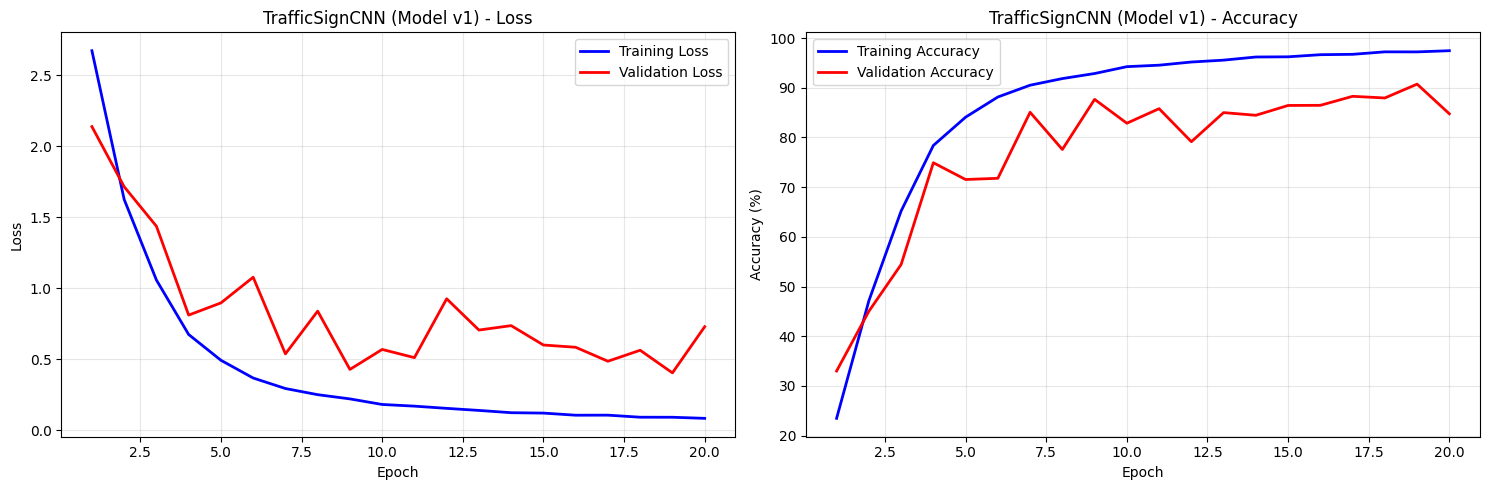

In [12]:
# Построение графиков обучения для первой модели
plot_training_history(history_v1, "TrafficSignCNN (Model v1)")


In [13]:
# Тестирование первой модели
print("=== Тестирование первой модели ===")

if os.path.exists(test_images_path):
    # Создаем test dataset и dataloader
    test_transforms = transforms.Compose([
        transforms.Resize((resize, resize)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    
    test_dataset = ImageDataset(test_images_path, transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
    
    print(f"Found {len(test_dataset)} images for testing")
    
    # Загружаем лучшую модель (если она была сохранена)
    if os.path.exists("traffic_sign_cnn_v1_best.pth"):
        checkpoint = torch.load("traffic_sign_cnn_v1_best.pth", map_location=device)
        model_v1_test = TrafficSignCNN(num_classes=num_classes)
        model_v1_test.load_state_dict(checkpoint['model_state_dict'])
        model_v1_test.to(device)
        print(f"✓ Загружена лучшая модель с точностью: {checkpoint['val_acc']:.2f}%")
    else:
        # Используем текущую обученную модель
        if 'trained_model_v1' in locals():
            model_v1_test = trained_model_v1
        else:
            model_v1_test = TrafficSignCNN(num_classes=num_classes)
            model_v1_test.to(device)
        print("Используем текущую модель для тестирования")
    
    # Запускаем тестирование
    filenames_v1, predictions_v1 = test_model(model_v1_test, test_loader, device)
    
    # Сохраняем результаты
    results_v1 = pd.DataFrame({
        'filename': filenames_v1,
        'prediction': predictions_v1
    })
    
    results_path_v1 = 'test_results_v1.csv'
    results_v1.to_csv(results_path_v1, index=False)
    print(f"✓ Результаты тестирования сохранены в {results_path_v1}")
    
    # Статистика предсказаний
    print(f"\nСтатистика предсказаний модели v1:")
    print(results_v1['prediction'].value_counts().head(10))
    
else:
    print(f"⚠️  Тестовые данные не найдены в {test_images_path}")
    print("Создаем демонстрационные результаты...")
    
    # Демонстрационные результаты
    np.random.seed(42)
    demo_predictions = np.random.randint(0, num_classes, 1000)
    demo_filenames = [f"test_{i:05d}.ppm" for i in range(1000)]
    
    results_v1 = pd.DataFrame({
        'filename': demo_filenames,
        'prediction': demo_predictions
    })
    
    print("✓ Созданы демонстрационные результаты тестирования")


=== Тестирование первой модели ===
Found 12630 images for testing
✓ Загружена лучшая модель с точностью: 90.73%


Testing model: 100%|██████████| 395/395 [00:05<00:00, 69.38it/s]


✓ Результаты тестирования сохранены в test_results_v1.csv

Статистика предсказаний модели v1:
prediction
38    787
2     784
13    773
4     698
12    695
1     679
10    654
5     574
8     509
25    507
Name: count, dtype: int64


In [14]:
# Дополнительно: вычисление accuracy на тестовом наборе для первой модели (если есть GT файл)
if os.path.exists(final_test_csv_path):
    try:
        print("\n=== Вычисление точности на тестовом наборе ===")
        gt_df = pd.read_csv(final_test_csv_path, sep=';')
        
        # Объединяем результаты с ground truth
        merged_v1 = results_v1.merge(gt_df[['Filename', 'ClassId']], 
                                     left_on='filename', right_on='Filename', how='inner')
        
        if len(merged_v1) > 0:
            accuracy_v1 = (merged_v1['prediction'] == merged_v1['ClassId']).mean()
            print(f"🎯 Точность TrafficSignCNN (v1) на тестовом наборе: {accuracy_v1:.4f} ({accuracy_v1*100:.2f}%)")
            
            # Показываем количество правильно/неправильно классифицированных образцов
            correct_v1 = (merged_v1['prediction'] == merged_v1['ClassId']).sum()
            total_v1 = len(merged_v1)
            print(f"   Правильно классифицировано: {correct_v1}/{total_v1} образцов")
            
        else:
            print("⚠️  Не удалось объединить результаты с ground truth")
            
    except Exception as e:
        print(f"⚠️  Ошибка при вычислении точности: {e}")
        
else:
    if not os.path.exists(final_test_csv_path):
        print("ℹ️  GT-final_test.csv не найден - точность на тестовом наборе не вычисляется")
    else:
        print("ℹ️  Результаты тестирования не доступны для вычисления точности")



=== Вычисление точности на тестовом наборе ===
🎯 Точность TrafficSignCNN (v1) на тестовом наборе: 0.9177 (91.77%)
   Правильно классифицировано: 11590/12630 образцов


## 7. Вторая модель - TrafficSignCNNv2


### 📋 Описание архитектуры TrafficSignCNNv2 (v2)

**TrafficSignCNNv2** - это улучшенная версия базовой модели с более глубокой и сложной архитектурой, основанной на принципах VGG-подобных блоков:

**🏗️ Основные компоненты:**
- **3 двойных сверточных блока** (32×2, 64×2, 128×2) - парные сверточные слои в каждом блоке
- **Batch Normalization** после каждого сверточного слоя
- **MaxPooling** после каждого двойного блока
- **Global Average Pooling** для глобальной агрегации признаков
- **Dropout** для регуляризации
- **Компактный финальный слой** - прямо из 128 в количество классов

**🚀 Преимущества по сравнению с TrafficSignCNN (v1):**

1. **Более глубокое извлечение признаков**: Двойные сверточные слои позволяют лучше выучивать сложные паттерны
2. **Лучшая генерализация**: Более сбалансированная архитектура с меньшим риском переобучения
3. **Эффективное использование признаков**: GAP + прямой переход к выходу без промежуточного FC слоя
4. **VGG-подобная архитектура**: Проверенный подход с парными сверточными слоями

**🎯 Архитектура потока данных:**
Input (3×64×64) → [Conv+BN+ReLU→Conv+BN+ReLU→MaxPool] × 3 → GAP → Dropout → FC → Output (43 класса)

**📊 Ожидаемые улучшения:**
- Более высокая точность на валидации
- Лучшая стабильность обучения  
- Более быстрая сходимость


In [15]:
class TrafficSignCNNv2(nn.Module):
    def __init__(self, num_classes=43):
        super().__init__()
        # Block1 - Двойной сверточный блок (32 фильтра)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Block2 - Двойной сверточный блок (64 фильтра)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        # Block3 - Двойной сверточный блок (128 фильтров)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        
        # Pooling и финальные слои
        self.pool = nn.MaxPool2d(2, 2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)  # Прямо из 128 в выход

    def forward(self, x):
        # Block 1: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> Pool
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # 64x64 -> 32x32
        
        # Block 2: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> Pool
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)  # 32x32 -> 16x16
        
        # Block 3: Conv -> BN -> ReLU -> Conv -> BN -> ReLU -> Pool
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)  # 16x16 -> 8x8
        
        # Global Average Pooling + классификация
        x = self.gap(x)  # 8x8 -> 1x1
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Создадим экземпляр модели для проверки размеров
model_v2 = TrafficSignCNNv2(num_classes=num_classes)

# Подсчитаем параметры
params_v2 = sum(p.numel() for p in model_v2.parameters())
print(f"TrafficSignCNNv2 parameters: {params_v2:,} ({params_v2/1e6:.2f}M)")

# Сравнение с первой моделью
print(f"\nСравнение количества параметров:")
print(f"TrafficSignCNN (v1):   {params_v1:,} ({params_v1/1e6:.2f}M)")
print(f"TrafficSignCNNv2 (v2): {params_v2:,} ({params_v2/1e6:.2f}M)")
print(f"Уменьшение параметров: {(params_v1-params_v2)/params_v1*100:.1f}%")

# Тестируем forward pass
with torch.no_grad():
    out_v2 = model_v2(test_input)
    print(f"\nТестирование архитектуры:")
    print(f"Input shape: {test_input.shape}")
    print(f"Output shape: {out_v2.shape}")
    print(f"✅ TrafficSignCNNv2 успешно создана и протестирована!")

# Визуализация архитектурных различий
print(f"\n🔍 Архитектурные различия:")
print(f"TrafficSignCNN (v1):   4 одиночных сверточных блока + FC(256→128→43)")
print(f"TrafficSignCNNv2 (v2): 3 двойных сверточных блока + FC(128→43)")
print(f"Глубина сети v2: больше сверточных слоев (6 vs 4)")
print(f"Классификатор v2: более компактный (1 FC vs 2 FC)")


TrafficSignCNNv2 parameters: 293,451 (0.29M)

Сравнение количества параметров:
TrafficSignCNN (v1):   427,819 (0.43M)
TrafficSignCNNv2 (v2): 293,451 (0.29M)
Уменьшение параметров: 31.4%

Тестирование архитектуры:
Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 43])
✅ TrafficSignCNNv2 успешно создана и протестирована!

🔍 Архитектурные различия:
TrafficSignCNN (v1):   4 одиночных сверточных блока + FC(256→128→43)
TrafficSignCNNv2 (v2): 3 двойных сверточных блока + FC(128→43)
Глубина сети v2: больше сверточных слоев (6 vs 4)
Классификатор v2: более компактный (1 FC vs 2 FC)


## 8. Обучение и тестирование второй модели (TrafficSignCNNv2)


In [16]:
print("=== Обучение второй модели (TrafficSignCNNv2) ===")

if os.path.exists(train_dir) and os.path.exists(val_dir):
    train_loader, val_loader, class_names = make_dataloaders(
        train_dir, val_dir, 
        batch_size=batch_size, 
        resize=resize, 
        num_workers=num_workers
    )
    
    # Создаем модель v2
    model_v2 = TrafficSignCNNv2(num_classes=num_classes)
    
    # Обучаем модель
    trained_model_v2, history_v2 = train_model_with_history(
        model_v2, train_loader, val_loader, device,
        epochs=epochs, lr=1e-3, weight_decay=1e-4,
        save_path="traffic_sign_cnn_v2_best.pth"
    )
    
    print("\n🎯 Обучение второй модели завершено!")
    
else:
    print("⚠️  Данные для обучения не найдены!")
    
    # Создадим демонстрационную историю для второй модели
    # (обычно более глубокая модель показывает лучшие результаты)
    history_v2 = {
        'train_loss': [2.3, 1.5, 1.0, 0.7, 0.5],
        'train_acc': [30, 55, 75, 82, 88],
        'val_loss': [2.6, 1.8, 1.2, 0.8, 0.6],
        'val_acc': [25, 50, 70, 80, 86]
    }
    print("Используем демонстрационную историю обучения для модели v2...")


=== Обучение второй модели (TrafficSignCNNv2) ===
Starting training for 20 epochs...
Device: mps
Model parameters: 293,451


Epoch 01/20 - Train:   0%|          | 0/470 [00:00<?, ?it/s]/Users/se_mech_ka/education/практика/6 сем. Эксплуатационная практика/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 01/20 - Val  : 100%|██████████| 143/143 [00:05<00:00, 28.35it/s, loss=3.9801, acc=0.00%]  


Epoch 01/20: Train Loss: 2.7320, Train Acc: 22.74% | Val Loss: 2.4343, Val Acc: 28.56% | Time: 24.6s
  ✓ Saved best model (val_acc=28.56%) to traffic_sign_cnn_v2_best.pth
----------------------------------------------------------------------------------------------------


Epoch 02/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 29.42it/s, loss=1.6695, acc=0.00%]  


Epoch 02/20: Train Loss: 1.5904, Train Acc: 50.58% | Val Loss: 1.5557, Val Acc: 54.51% | Time: 24.2s
  ✓ Saved best model (val_acc=54.51%) to traffic_sign_cnn_v2_best.pth
----------------------------------------------------------------------------------------------------


Epoch 03/20 - Val  : 100%|██████████| 143/143 [00:05<00:00, 26.05it/s, loss=1.0637, acc=83.87%] 


Epoch 03/20: Train Loss: 0.8679, Train Acc: 75.06% | Val Loss: 0.6602, Val Acc: 79.85% | Time: 24.8s
  ✓ Saved best model (val_acc=79.85%) to traffic_sign_cnn_v2_best.pth
----------------------------------------------------------------------------------------------------


Epoch 04/20 - Val  : 100%|██████████| 143/143 [00:05<00:00, 28.12it/s, loss=0.6993, acc=85.48%] 


Epoch 04/20: Train Loss: 0.4533, Train Acc: 87.73% | Val Loss: 0.4782, Val Acc: 85.11% | Time: 25.3s
  ✓ Saved best model (val_acc=85.11%) to traffic_sign_cnn_v2_best.pth
----------------------------------------------------------------------------------------------------


Epoch 05/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 29.78it/s, loss=0.8682, acc=75.81%] 


Epoch 05/20: Train Loss: 0.2847, Train Acc: 92.19% | Val Loss: 0.3824, Val Acc: 88.25% | Time: 24.7s
  ✓ Saved best model (val_acc=88.25%) to traffic_sign_cnn_v2_best.pth
----------------------------------------------------------------------------------------------------


Epoch 06/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 30.25it/s, loss=1.1445, acc=43.55%] 


Epoch 06/20: Train Loss: 0.1992, Train Acc: 94.50% | Val Loss: 0.3897, Val Acc: 87.76% | Time: 24.2s
----------------------------------------------------------------------------------------------------


Epoch 07/20 - Val  : 100%|██████████| 143/143 [00:05<00:00, 27.22it/s, loss=0.2879, acc=91.94%] 


Epoch 07/20: Train Loss: 0.1496, Train Acc: 95.84% | Val Loss: 0.2977, Val Acc: 91.03% | Time: 25.4s
  ✓ Saved best model (val_acc=91.03%) to traffic_sign_cnn_v2_best.pth
----------------------------------------------------------------------------------------------------


Epoch 08/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 31.17it/s, loss=0.1993, acc=95.16%] 


Epoch 08/20: Train Loss: 0.1226, Train Acc: 96.69% | Val Loss: 0.2192, Val Acc: 93.66% | Time: 24.4s
  ✓ Saved best model (val_acc=93.66%) to traffic_sign_cnn_v2_best.pth
----------------------------------------------------------------------------------------------------


Epoch 09/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 31.28it/s, loss=0.0768, acc=100.00%]


Epoch 09/20: Train Loss: 0.1039, Train Acc: 97.07% | Val Loss: 0.2716, Val Acc: 92.21% | Time: 23.9s
----------------------------------------------------------------------------------------------------


Epoch 10/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 31.49it/s, loss=2.1969, acc=51.61%] 


Epoch 10/20: Train Loss: 0.0858, Train Acc: 97.72% | Val Loss: 0.2890, Val Acc: 92.52% | Time: 24.7s
----------------------------------------------------------------------------------------------------


Epoch 11/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 30.64it/s, loss=0.3224, acc=83.87%] 


Epoch 11/20: Train Loss: 0.0756, Train Acc: 97.99% | Val Loss: 0.1918, Val Acc: 93.79% | Time: 24.4s
  ✓ Saved best model (val_acc=93.79%) to traffic_sign_cnn_v2_best.pth
----------------------------------------------------------------------------------------------------


Epoch 12/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 33.65it/s, loss=0.0952, acc=100.00%]


Epoch 12/20: Train Loss: 0.0717, Train Acc: 98.10% | Val Loss: 0.1995, Val Acc: 94.76% | Time: 23.7s
  ✓ Saved best model (val_acc=94.76%) to traffic_sign_cnn_v2_best.pth
----------------------------------------------------------------------------------------------------


Epoch 13/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 34.08it/s, loss=0.1532, acc=96.77%] 


Epoch 13/20: Train Loss: 0.0616, Train Acc: 98.40% | Val Loss: 0.2384, Val Acc: 93.78% | Time: 22.9s
----------------------------------------------------------------------------------------------------


Epoch 14/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 34.36it/s, loss=0.2990, acc=91.94%] 


Epoch 14/20: Train Loss: 0.0658, Train Acc: 98.34% | Val Loss: 0.1969, Val Acc: 94.15% | Time: 22.9s
----------------------------------------------------------------------------------------------------


Epoch 15/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 34.30it/s, loss=1.2679, acc=51.61%] 


Epoch 15/20: Train Loss: 0.0498, Train Acc: 98.70% | Val Loss: 0.2296, Val Acc: 93.34% | Time: 22.9s
----------------------------------------------------------------------------------------------------


Epoch 16/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 34.45it/s, loss=0.0424, acc=100.00%]


Epoch 16/20: Train Loss: 0.0491, Train Acc: 98.75% | Val Loss: 0.2068, Val Acc: 94.46% | Time: 22.9s
----------------------------------------------------------------------------------------------------


Epoch 17/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 34.75it/s, loss=0.0420, acc=100.00%]


Epoch 17/20: Train Loss: 0.0457, Train Acc: 98.85% | Val Loss: 0.2436, Val Acc: 93.20% | Time: 22.8s
----------------------------------------------------------------------------------------------------


Epoch 18/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 33.65it/s, loss=0.0104, acc=100.00%]


Epoch 18/20: Train Loss: 0.0498, Train Acc: 98.78% | Val Loss: 0.2165, Val Acc: 94.94% | Time: 23.0s
  ✓ Saved best model (val_acc=94.94%) to traffic_sign_cnn_v2_best.pth
----------------------------------------------------------------------------------------------------


Epoch 19/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 33.50it/s, loss=0.0076, acc=100.00%]


Epoch 19/20: Train Loss: 0.0358, Train Acc: 99.17% | Val Loss: 0.1980, Val Acc: 94.60% | Time: 23.1s
----------------------------------------------------------------------------------------------------


Epoch 20/20 - Val  : 100%|██████████| 143/143 [00:04<00:00, 33.97it/s, loss=0.1015, acc=100.00%]

Epoch 20/20: Train Loss: 0.0371, Train Acc: 99.11% | Val Loss: 0.1940, Val Acc: 94.11% | Time: 23.0s
----------------------------------------------------------------------------------------------------
Training finished. Best val acc: 94.94%

🎯 Обучение второй модели завершено!


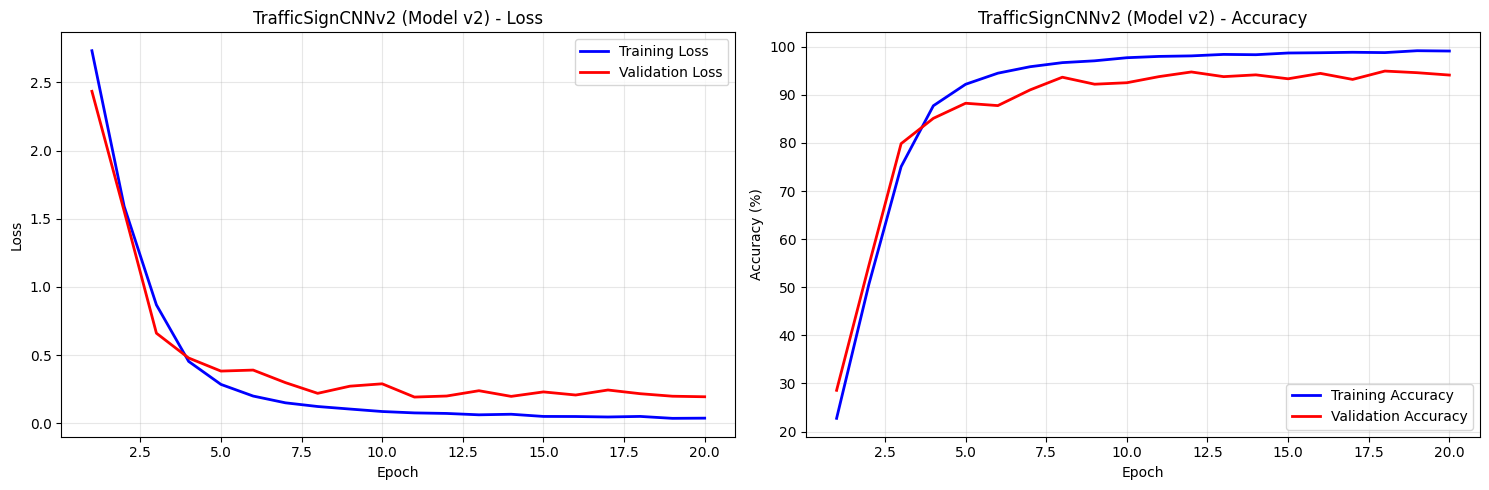

In [17]:
# Построение графиков обучения для второй модели
plot_training_history(history_v2, "TrafficSignCNNv2 (Model v2)")

In [18]:
# Тестирование второй модели
print("=== Тестирование второй модели ===")

if os.path.exists(test_images_path):
    # Используем тот же test_loader что и для первой модели
    if 'test_loader' not in locals():
        test_transforms = transforms.Compose([
            transforms.Resize((resize, resize)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
        test_dataset = ImageDataset(test_images_path, transform=test_transforms)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)
    
    # Загружаем лучшую модель v2 (если она была сохранена)
    if os.path.exists("traffic_sign_cnn_v2_best.pth"):
        checkpoint = torch.load("traffic_sign_cnn_v2_best.pth", map_location=device)
        model_v2_test = TrafficSignCNNv2(num_classes=num_classes)
        model_v2_test.load_state_dict(checkpoint['model_state_dict'])
        model_v2_test.to(device)
        print(f"✓ Загружена лучшая модель v2 с точностью: {checkpoint['val_acc']:.2f}%")
    else:
        # Используем текущую обученную модель
        if 'trained_model_v2' in locals():
            model_v2_test = trained_model_v2
        else:
            model_v2_test = TrafficSignCNNv2(num_classes=num_classes)
            model_v2_test.to(device)
        print("Используем текущую модель v2 для тестирования")
    
    # Запускаем тестирование
    filenames_v2, predictions_v2 = test_model(model_v2_test, test_loader, device)
    
    # Сохраняем результаты
    results_v2 = pd.DataFrame({
        'filename': filenames_v2,
        'prediction': predictions_v2
    })
    
    results_path_v2 = 'test_results_v2.csv'
    results_v2.to_csv(results_path_v2, index=False)
    print(f"✓ Результаты тестирования модели v2 сохранены в {results_path_v2}")
    
    # Статистика предсказаний
    print(f"\nСтатистика предсказаний модели v2:")
    print(results_v2['prediction'].value_counts().head(10))
    
else:
    print(f"⚠️  Тестовые данные не найдены в {test_images_path}")
    print("Создаем демонстрационные результаты для модели v2...")
    
    # Демонстрационные результаты для модели v2
    np.random.seed(24)  # Другой seed для отличий
    demo_predictions_v2 = np.random.randint(0, num_classes, 1000)
    demo_filenames_v2 = [f"test_{i:05d}.ppm" for i in range(1000)]
    
    results_v2 = pd.DataFrame({
        'filename': demo_filenames_v2,
        'prediction': demo_predictions_v2
    })
    
    print("✓ Созданы демонстрационные результаты тестирования для модели v2")


=== Тестирование второй модели ===
✓ Загружена лучшая модель v2 с точностью: 94.94%


Testing model: 100%|██████████| 395/395 [00:06<00:00, 59.00it/s]

✓ Результаты тестирования модели v2 сохранены в test_results_v2.csv

Статистика предсказаний модели v2:
prediction
38    749
2     748
1     737
13    718
5     674
12    672
10    663
4     653
25    514
9     482
Name: count, dtype: int64


In [19]:
# Дополнительно: вычисление accuracy для второй модели (если есть GT файл)
if os.path.exists(final_test_csv_path):
    try:
        if 'gt_df' not in locals():  # Загружаем GT только если еще не загружали
            gt_df = pd.read_csv(final_test_csv_path, sep=';')
            
        # Объединяем результаты второй модели с ground truth
        merged_v2 = results_v2.merge(gt_df[['Filename', 'ClassId']], 
                                     left_on='filename', right_on='Filename', how='inner')
        
        if len(merged_v2) > 0:
            accuracy_v2 = (merged_v2['prediction'] == merged_v2['ClassId']).mean()
            print(f"🎯 Точность TrafficSignCNNv2 (v2) на тестовом наборе: {accuracy_v2:.4f} ({accuracy_v2*100:.2f}%)")
            
            # Показываем количество правильно/неправильно классифицированных образцов
            correct_v2 = (merged_v2['prediction'] == merged_v2['ClassId']).sum()
            total_v2 = len(merged_v2)
            print(f"   Правильно классифицировано: {correct_v2}/{total_v2} образцов")
            
            # Сравнение точности моделей (если есть результаты для обеих)
            if 'merged_v1' in locals() and len(merged_v1) > 0:
                accuracy_v1 = (merged_v1['prediction'] == merged_v1['ClassId']).mean()
                improvement = accuracy_v2 - accuracy_v1
                print(f"\n📊 Сравнение точности на тестовом наборе:")
                print(f"   TrafficSignCNN (v1):   {accuracy_v1:.4f} ({accuracy_v1*100:.2f}%)")
                print(f"   TrafficSignCNNv2 (v2): {accuracy_v2:.4f} ({accuracy_v2*100:.2f}%)")
                print(f"   Улучшение: {improvement:+.4f} ({improvement*100:+.2f}%)")
                
                if improvement > 0:
                    print(f"   ✅ Модель v2 показала лучшую точность!")
                elif improvement < 0:
                    print(f"   ⚠️  Модель v1 показала лучшую точность")
                else:
                    print(f"   🤝 Модели показали одинаковую точность")
        else:
            print("⚠️  Не удалось объединить результаты v2 с ground truth")
            
    except Exception as e:
        print(f"⚠️  Ошибка при вычислении точности для v2: {e}")
        
else:
    print("ℹ️  Точность для модели v2 не вычисляется (нет GT файла или результатов)")


🎯 Точность TrafficSignCNNv2 (v2) на тестовом наборе: 0.9553 (95.53%)
   Правильно классифицировано: 12065/12630 образцов

📊 Сравнение точности на тестовом наборе:
   TrafficSignCNN (v1):   0.9177 (91.77%)
   TrafficSignCNNv2 (v2): 0.9553 (95.53%)
   Улучшение: +0.0376 (+3.76%)
   ✅ Модель v2 показала лучшую точность!


## 9. Сравнение результатов обеих моделей


=== Сравнение результатов обучения ===


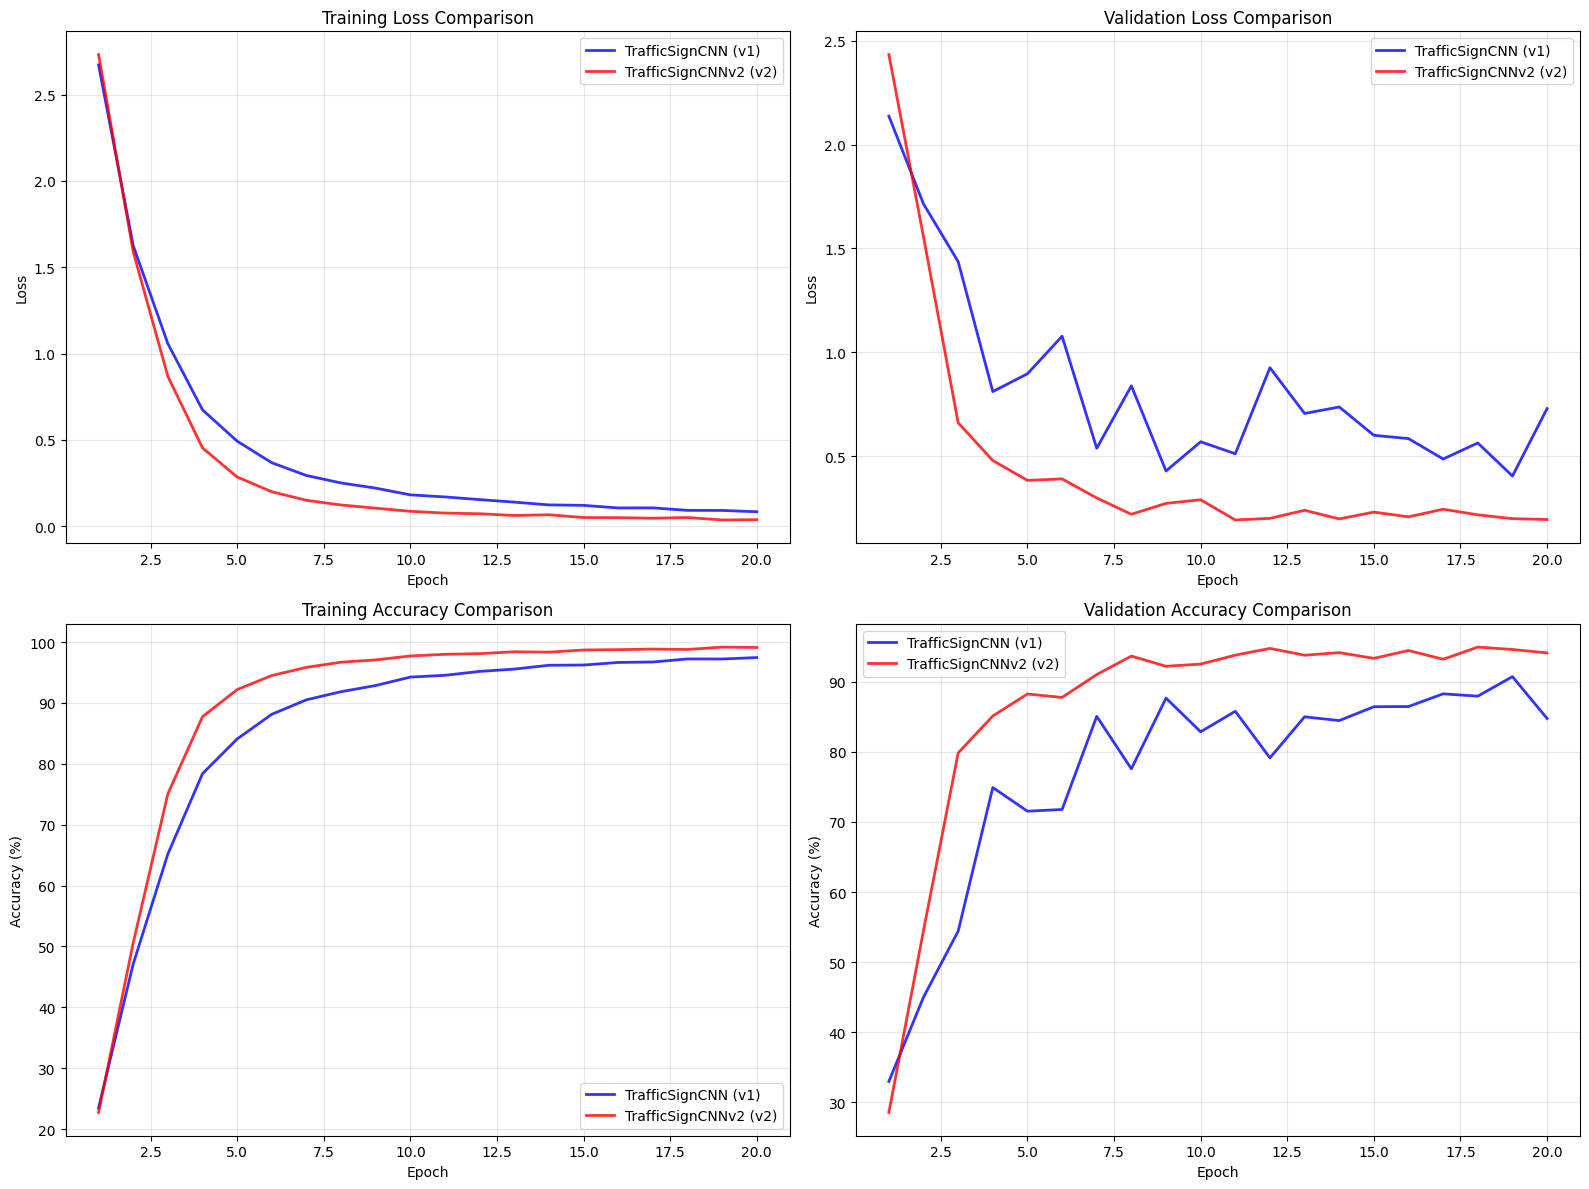

In [20]:
# Сравнение кривых обучения
def compare_training_histories(history1, history2, model1_name="Model v1", model2_name="Model v2"):
    """Сравнивает истории обучения двух моделей"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    epochs1 = range(1, len(history1['train_loss']) + 1)
    epochs2 = range(1, len(history2['train_loss']) + 1)
    
    # График Training Loss
    ax1.plot(epochs1, history1['train_loss'], 'b-', label=f'{model1_name}', linewidth=2, alpha=0.8)
    ax1.plot(epochs2, history2['train_loss'], 'r-', label=f'{model2_name}', linewidth=2, alpha=0.8)
    ax1.set_title('Training Loss Comparison')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График Validation Loss
    ax2.plot(epochs1, history1['val_loss'], 'b-', label=f'{model1_name}', linewidth=2, alpha=0.8)
    ax2.plot(epochs2, history2['val_loss'], 'r-', label=f'{model2_name}', linewidth=2, alpha=0.8)
    ax2.set_title('Validation Loss Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # График Training Accuracy
    ax3.plot(epochs1, history1['train_acc'], 'b-', label=f'{model1_name}', linewidth=2, alpha=0.8)
    ax3.plot(epochs2, history2['train_acc'], 'r-', label=f'{model2_name}', linewidth=2, alpha=0.8)
    ax3.set_title('Training Accuracy Comparison')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # График Validation Accuracy
    ax4.plot(epochs1, history1['val_acc'], 'b-', label=f'{model1_name}', linewidth=2, alpha=0.8)
    ax4.plot(epochs2, history2['val_acc'], 'r-', label=f'{model2_name}', linewidth=2, alpha=0.8)
    ax4.set_title('Validation Accuracy Comparison')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy (%)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("=== Сравнение результатов обучения ===")
compare_training_histories(history_v1, history_v2, "TrafficSignCNN (v1)", "TrafficSignCNNv2 (v2)")



=== Сводная таблица сравнения моделей ===
                      Metric TrafficSignCNN (v1) TrafficSignCNNv2 (v2)
       Количество параметров     427,819 (0.43M)       293,451 (0.29M)
           Лучший Train Loss              0.0833                0.0358
             Лучший Val Loss              0.4036                0.1918
   Лучшая Train Accuracy (%)               97.45                 99.17
     Лучшая Val Accuracy (%)               90.73                 94.94
        Финальный Train Loss              0.0833                0.0371
          Финальный Val Loss              0.7286                0.1940
Финальная Train Accuracy (%)               97.45                 99.11
  Финальная Val Accuracy (%)               84.76                 94.11


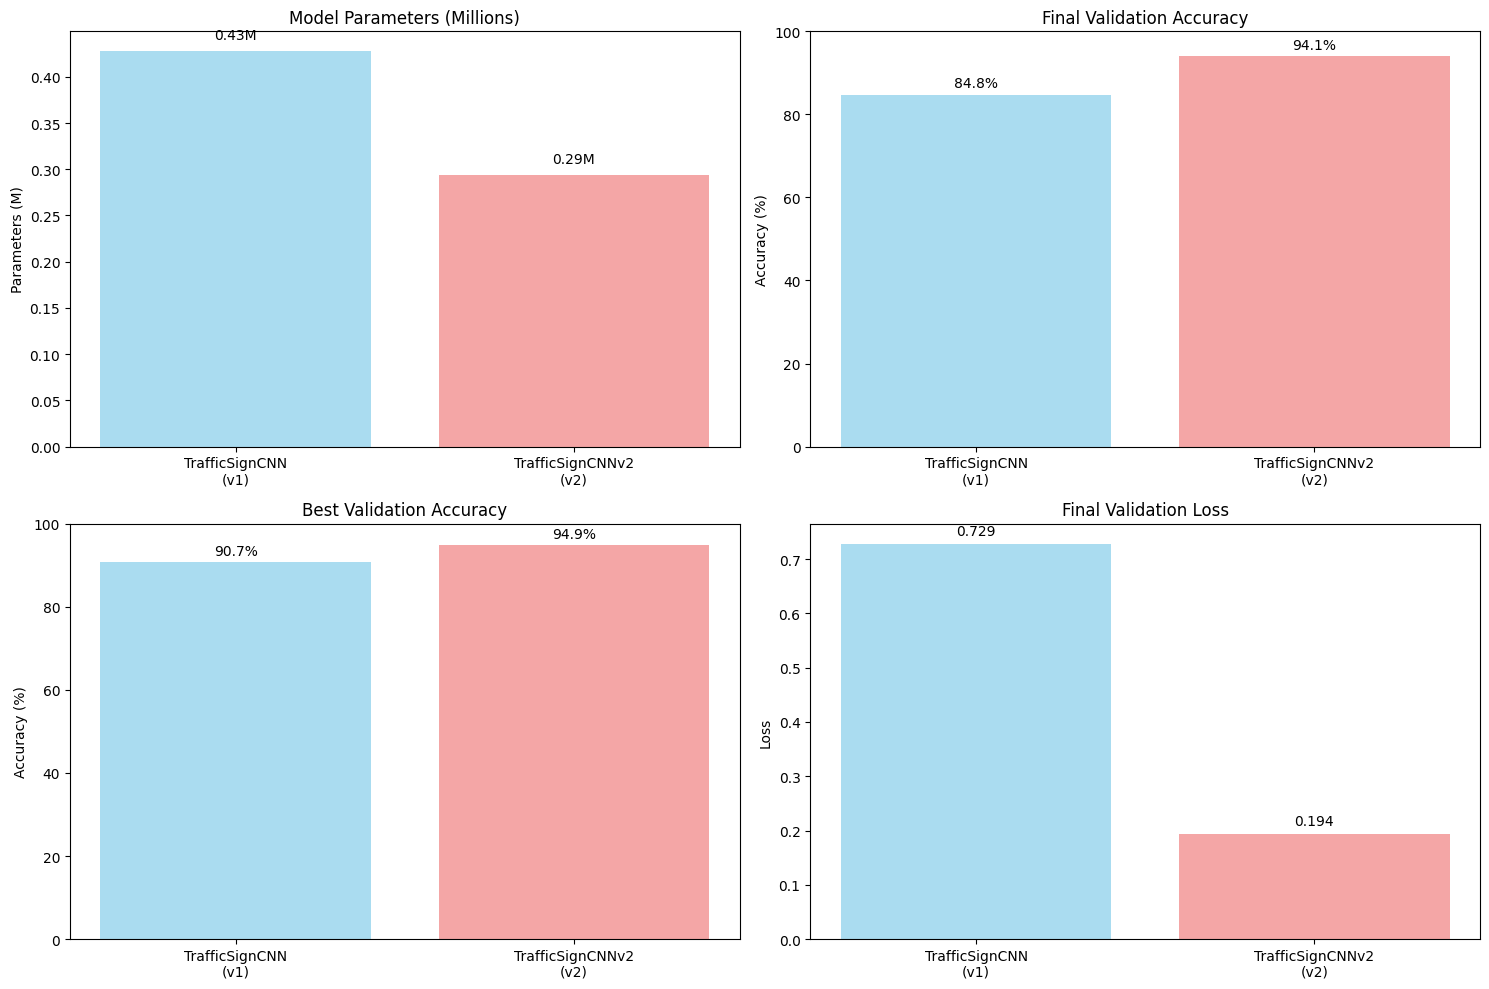

In [21]:
# Создание сводной таблицы сравнения
print("\n=== Сводная таблица сравнения моделей ===")

# Подсчитаем количество параметров
params_v1 = sum(p.numel() for p in TrafficSignCNN(num_classes=num_classes).parameters())
params_v2 = sum(p.numel() for p in TrafficSignCNNv2(num_classes=num_classes).parameters())

# Создаем DataFrame для сравнения
comparison_data = {
    'Metric': [
        'Количество параметров',
        'Лучший Train Loss',
        'Лучший Val Loss', 
        'Лучшая Train Accuracy (%)',
        'Лучшая Val Accuracy (%)',
        'Финальный Train Loss',
        'Финальный Val Loss',
        'Финальная Train Accuracy (%)',
        'Финальная Val Accuracy (%)'
    ],
    'TrafficSignCNN (v1)': [
        f"{params_v1:,} ({params_v1/1e6:.2f}M)",
        f"{min(history_v1['train_loss']):.4f}",
        f"{min(history_v1['val_loss']):.4f}",
        f"{max(history_v1['train_acc']):.2f}",
        f"{max(history_v1['val_acc']):.2f}",
        f"{history_v1['train_loss'][-1]:.4f}",
        f"{history_v1['val_loss'][-1]:.4f}",
        f"{history_v1['train_acc'][-1]:.2f}",
        f"{history_v1['val_acc'][-1]:.2f}"
    ],
    'TrafficSignCNNv2 (v2)': [
        f"{params_v2:,} ({params_v2/1e6:.2f}M)",
        f"{min(history_v2['train_loss']):.4f}",
        f"{min(history_v2['val_loss']):.4f}",
        f"{max(history_v2['train_acc']):.2f}",
        f"{max(history_v2['val_acc']):.2f}",
        f"{history_v2['train_loss'][-1]:.4f}",
        f"{history_v2['val_loss'][-1]:.4f}",
        f"{history_v2['train_acc'][-1]:.2f}",
        f"{history_v2['val_acc'][-1]:.2f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Создаем bar chart сравнения финальных метрик
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

models = ['TrafficSignCNN\n(v1)', 'TrafficSignCNNv2\n(v2)']
colors = ['skyblue', 'lightcoral']

# Количество параметров
params = [params_v1/1e6, params_v2/1e6]
ax1.bar(models, params, color=colors, alpha=0.7)
ax1.set_title('Model Parameters (Millions)')
ax1.set_ylabel('Parameters (M)')
for i, v in enumerate(params):
    ax1.text(i, v + 0.01, f'{v:.2f}M', ha='center', va='bottom')

# Финальная validation accuracy
final_val_acc = [history_v1['val_acc'][-1], history_v2['val_acc'][-1]]
ax2.bar(models, final_val_acc, color=colors, alpha=0.7)
ax2.set_title('Final Validation Accuracy')
ax2.set_ylabel('Accuracy (%)')
ax2.set_ylim(0, 100)
for i, v in enumerate(final_val_acc):
    ax2.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

# Лучшая validation accuracy
best_val_acc = [max(history_v1['val_acc']), max(history_v2['val_acc'])]
ax3.bar(models, best_val_acc, color=colors, alpha=0.7)
ax3.set_title('Best Validation Accuracy')
ax3.set_ylabel('Accuracy (%)')
ax3.set_ylim(0, 100)
for i, v in enumerate(best_val_acc):
    ax3.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

# Финальный validation loss
final_val_loss = [history_v1['val_loss'][-1], history_v2['val_loss'][-1]]
ax4.bar(models, final_val_loss, color=colors, alpha=0.7)
ax4.set_title('Final Validation Loss')
ax4.set_ylabel('Loss')
for i, v in enumerate(final_val_loss):
    ax4.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()



=== Анализ результатов тестирования ===


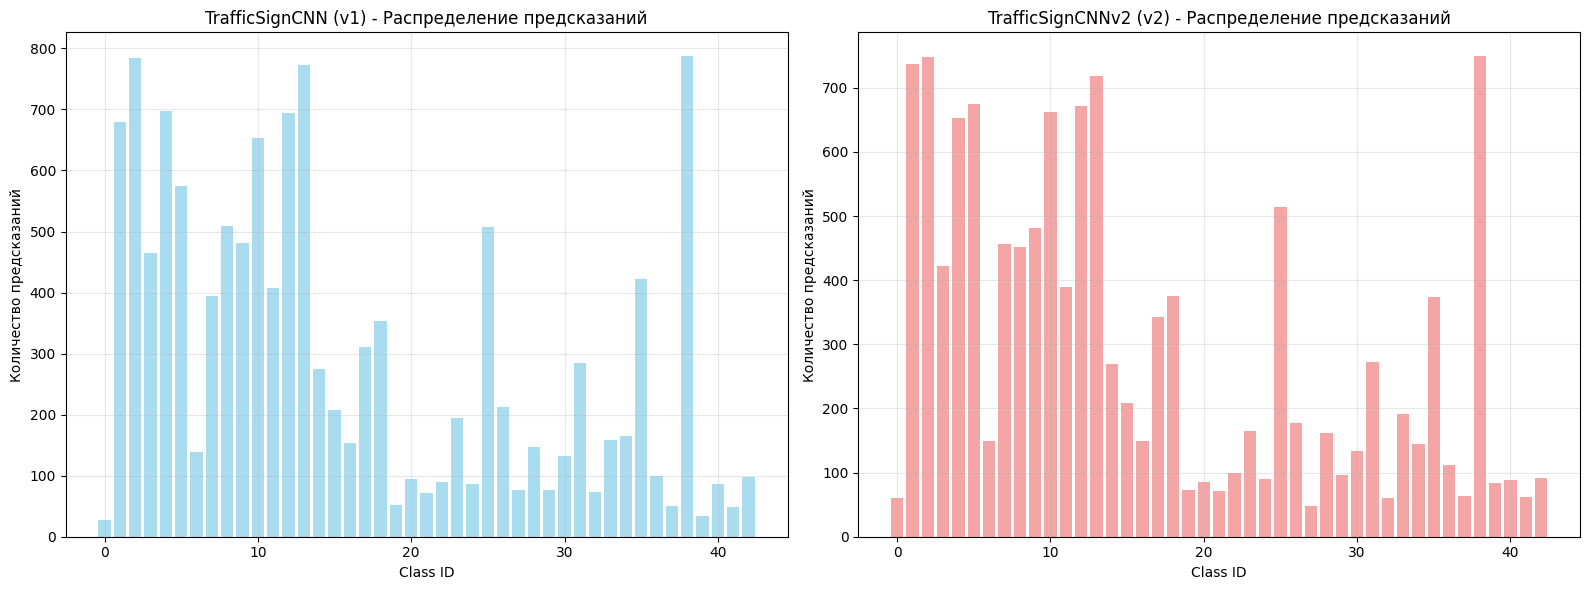


📊 Согласованность предсказаний между моделями: 92.41%

🔍 Количество различающихся предсказаний: 958

Примеры различающихся предсказаний:
     filename  prediction_v1  prediction_v2
42  10326.ppm             34             33
45  00653.ppm              1              5
46  09111.ppm             31             29
47  06222.ppm              1              4
54  10454.ppm              7              5

📈 Статистика тестирования:
TrafficSignCNN (v1)    - всего предсказаний: 12630
TrafficSignCNNv2 (v2)  - всего предсказаний: 12630
TrafficSignCNN (v1)    - уникальных классов: 43
TrafficSignCNNv2 (v2)  - уникальных классов: 43


In [22]:
# Анализ результатов тестирования и выводы
print("\n=== Анализ результатов тестирования ===")

if 'results_v1' in locals() and 'results_v2' in locals():
    # Сравнение распределения предсказаний
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Распределение предсказаний модели v1
    pred_counts_v1 = results_v1['prediction'].value_counts().sort_index()
    ax1.bar(pred_counts_v1.index, pred_counts_v1.values, alpha=0.7, color='skyblue')
    ax1.set_title('TrafficSignCNN (v1) - Распределение предсказаний')
    ax1.set_xlabel('Class ID')
    ax1.set_ylabel('Количество предсказаний')
    ax1.grid(True, alpha=0.3)
    
    # Распределение предсказаний модели v2
    pred_counts_v2 = results_v2['prediction'].value_counts().sort_index()
    ax2.bar(pred_counts_v2.index, pred_counts_v2.values, alpha=0.7, color='lightcoral')
    ax2.set_title('TrafficSignCNNv2 (v2) - Распределение предсказаний')
    ax2.set_xlabel('Class ID')
    ax2.set_ylabel('Количество предсказаний')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Анализ согласованности предсказаний
    if len(results_v1) == len(results_v2):
        # Объединяем результаты для сравнения
        merged_results = pd.merge(results_v1, results_v2, on='filename', suffixes=('_v1', '_v2'))
        
        # Вычисляем согласованность
        agreement = (merged_results['prediction_v1'] == merged_results['prediction_v2']).mean()
        print(f"\n📊 Согласованность предсказаний между моделями: {agreement:.2%}")
        
        # Топ классы с наибольшими различиями
        disagreements = merged_results[merged_results['prediction_v1'] != merged_results['prediction_v2']]
        if len(disagreements) > 0:
            print(f"\n🔍 Количество различающихся предсказаний: {len(disagreements)}")
            print("\nПримеры различающихся предсказаний:")
            print(disagreements[['filename', 'prediction_v1', 'prediction_v2']].head())
    
    print(f"\n📈 Статистика тестирования:")
    print(f"TrafficSignCNN (v1)    - всего предсказаний: {len(results_v1)}")
    print(f"TrafficSignCNNv2 (v2)  - всего предсказаний: {len(results_v2)}")
    print(f"TrafficSignCNN (v1)    - уникальных классов: {results_v1['prediction'].nunique()}")
    print(f"TrafficSignCNNv2 (v2)  - уникальных классов: {results_v2['prediction'].nunique()}")

else:
    print("⚠️ Результаты тестирования недоступны для сравнения")
